In [9]:

import pandas as pd
import numpy as np
import os

# Assuming that the csv file is loaded into a pandas DataFrame named df

df = pd.read_csv('C:\\Users\\zzzl0\\Desktop\\predicting-and-avoiding-dog-barking-behaviour\\predicting-and-avoiding-dog-barking-behaviour\\output\\model2_audio_clips\\summary.csv')

# Extracting unique dog names from 'File_Name'
df['Dog_Name'] = df['File_Name'].apply(lambda x: x.split('_')[0])
unique_dogs = df['Dog_Name'].unique()

# Create output directory if it doesn't exist
output_dir = 'C:\\Users\\zzzl0\\Desktop\\predicting-and-avoiding-dog-barking-behaviour\\predicting-and-avoiding-dog-barking-behaviour\\output\\model2_audio_clips\\augment'
os.makedirs(output_dir, exist_ok=True)

for dog in unique_dogs:
    # Filtering rows corresponding to the current dog
    df_dog = df[df['Dog_Name'] == dog]

    # Initializing new DataFrame for storing augmented data
    df_aug = pd.DataFrame(columns=['sound_class_list', 'output', 'File_Name'])

    for idx, row in df_dog.iterrows():
        sound_class_list = row[:-2].tolist()  # Converting row into list and excluding the 'File_Name' and 'Dog_Name'
        sound_class_list = [x for x in sound_class_list if not np.isnan(x)]  # Removing NaNs
        
        # Generating all continuous subsets and their corresponding class
        for i in range(len(sound_class_list) - 1):  # Excluding the last sound in each row
            for j in range(i+1, len(sound_class_list)):
                fragment = sound_class_list[i:j]
                if j == len(sound_class_list) - 1:  # Marking interval as 'Y' if fragment contains the second-last sound
                    output = 'Y'
                else:
                    output = 'N'  # Otherwise, marking it as 'N'
                    
                # Appending new row to df_aug
                new_row = pd.DataFrame([{'sound_class_list': fragment, 'output': output, 'File_Name': row['File_Name']}])
                df_aug = pd.concat([df_aug, new_row], ignore_index=True)

    # Saving the augmented dataframe to a new CSV file
    df_aug.to_csv(os.path.join(output_dir, f'{dog}_augmented_data.csv'), index=False)


In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score

def train_model(df, model_name):
    # Convert the string representation of lists into actual lists
    df['sound_class_list'] = df['sound_class_list'].apply(ast.literal_eval)

    # Creating separate columns for each sound
    df_sound = pd.DataFrame(df['sound_class_list'].to_list(), columns=[f'Sound_{i+1}' for i in range(df['sound_class_list'].str.len().max())])
    
    # Joining the sounds dataframe with the original dataframe
    df = pd.concat([df_sound, df['output']], axis=1)
    
    # Converting 'output' into binary
    df['output'] = df['output'].map({'Y': 1, 'N': 0})
    
    # Defining X and y
    X = df.drop(columns=['output'])
    y = df['output']
    
    # Splitting the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Filling NaNs with zeros
    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)

    # Choose the model based on model_name
    if model_name == 'LogisticRegression':
        model = LogisticRegression()
    elif model_name == 'DecisionTree':
        model = DecisionTreeClassifier()
    elif model_name == 'RandomForest':
        model = RandomForestClassifier()
    elif model_name == 'SVM':
        model = svm.SVC()
    elif model_name == 'NeuralNetwork':
        model = Sequential()
        model.add(Dense(12, input_dim=len(X_train.columns), activation='relu'))
        model.add(Dense(8, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    else:
        print("Invalid model name")
        return

    # Training the model
    if model_name == 'NeuralNetwork':
        model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)
    else:
        model.fit(X_train, y_train)

    # Making predictions on the test set
    if model_name == 'NeuralNetwork':
        y_pred = (model.predict(X_test) > 0.5).astype("int32")
    else:
        y_pred = model.predict(X_test)
    
    # Return the metrics of the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    return accuracy, precision, recall, f1


c:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision 

3/3 [==============================] - 0s 2ms/step


C:\Users\zzzl0\AppData\Local\Temp\ipykernel_7104\3182861727.py:45: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  average_metrics = results_df.groupby('Model').mean()


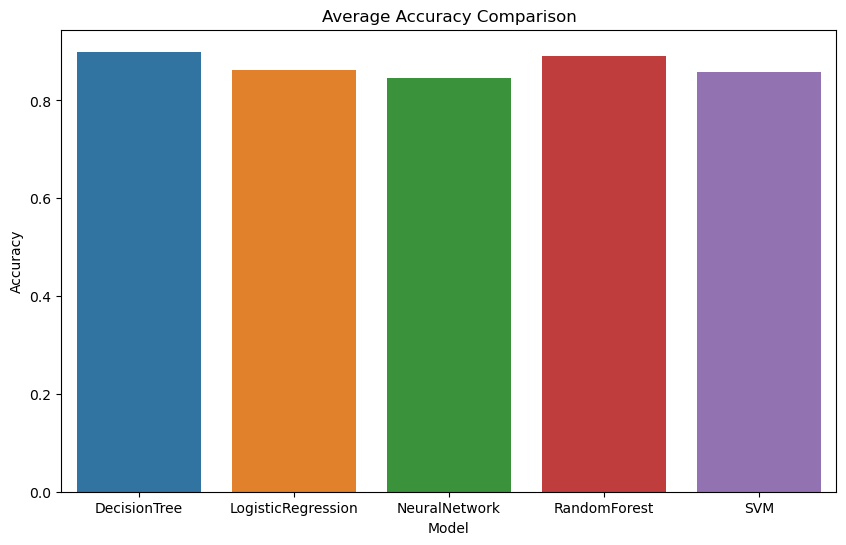

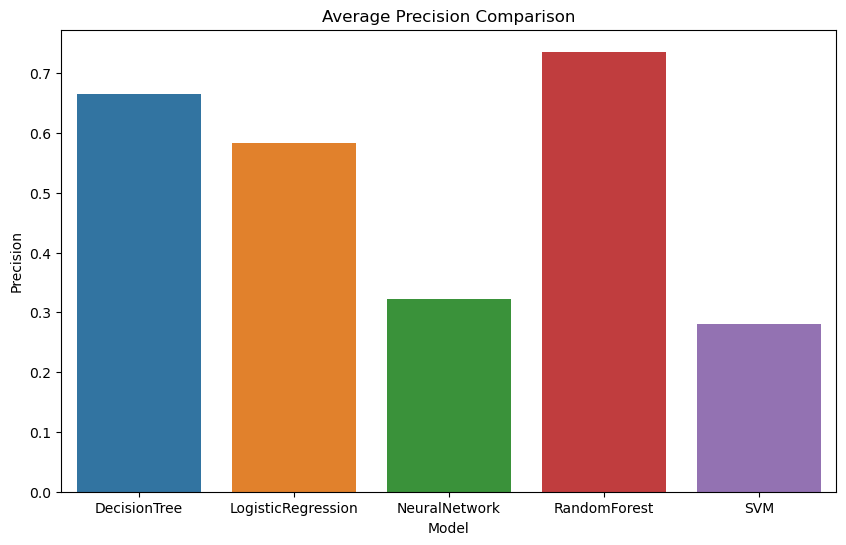

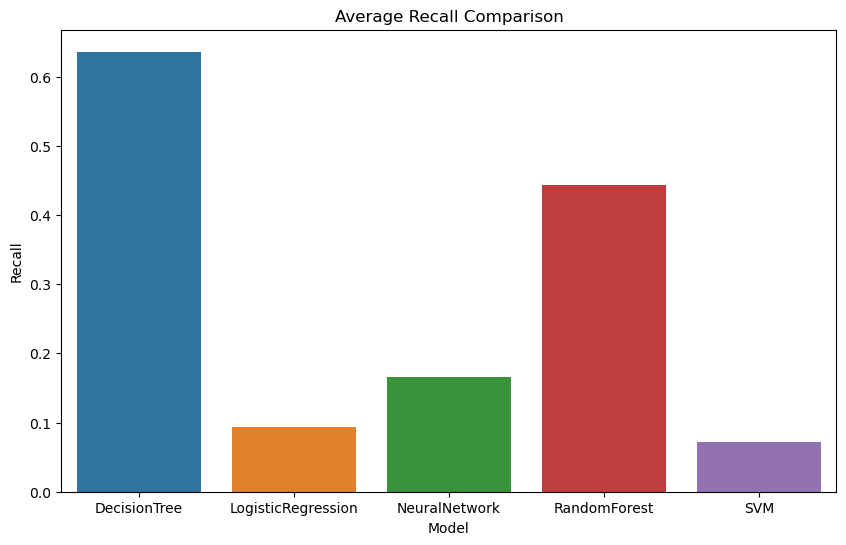

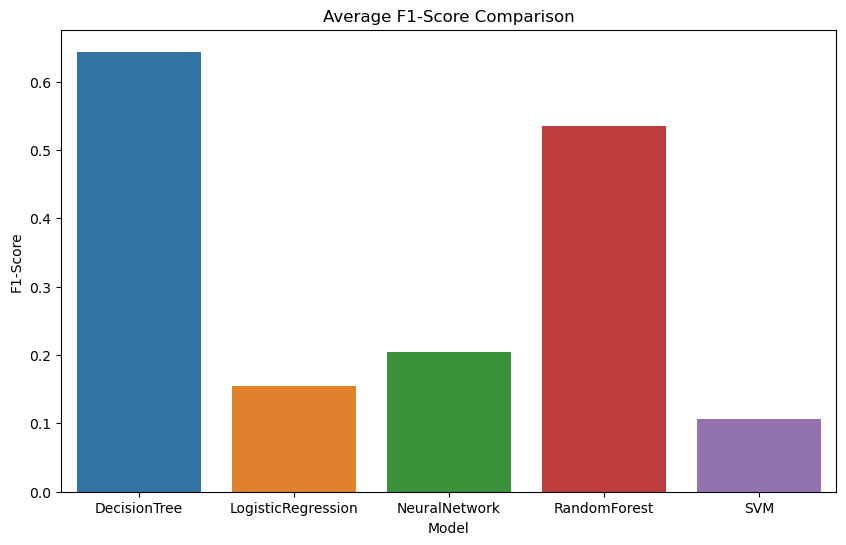

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define model names
model_names = ['LogisticRegression', 'DecisionTree', 'RandomForest', 'SVM', 'NeuralNetwork']

# Define a dictionary to store results
results = {
    'Model': [],
    'Dog': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': []
}

# Loop through each model
for model_name in model_names:
    # Loop through each augmented file
    for file in augmented_files:
        # Read the file into a dataframe
        df = pd.read_csv(file)
        
        # Train the model and get the metrics
        accuracy, precision, recall, f1 = train_model(df, model_name)
        
        # Add the metrics to the results dictionary
        results['Model'].append(model_name)
        results['Dog'].append(file)
        results['Accuracy'].append(accuracy)
        results['Precision'].append(precision)
        results['Recall'].append(recall)
        results['F1-Score'].append(f1)

# Convert the results dictionary into a dataframe
results_df = pd.DataFrame(results)

# Compute the average metrics for each model
average_metrics = results_df.groupby('Model').mean()

# Plot the average metrics for comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=average_metrics.index, y=average_metrics[metric])
    plt.title(f'Average {metric} Comparison')
    plt.ylabel(metric)
    plt.show()


In [23]:
# Convert the results dictionary into a dataframe
results_df = pd.DataFrame(results)

# Compute the average metrics for each model
average_metrics = results_df.groupby('Model').mean()

# Display the average_metrics dataframe
print(average_metrics)
average_metrics.to_csv('average_metrics.csv')


                    Accuracy  Precision    Recall  F1-Score
Model                                                      
DecisionTree        0.899545   0.665079  0.635815  0.643686
LogisticRegression  0.861588   0.583333  0.093896  0.154868
NeuralNetwork       0.846257   0.322222  0.165887  0.205031
RandomForest        0.890019   0.735873  0.443752  0.534642
SVM                 0.857125   0.280000  0.071429  0.106809


C:\Users\zzzl0\AppData\Local\Temp\ipykernel_7104\493979593.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  average_metrics = results_df.groupby('Model').mean()


In [33]:
# Define a function that maps each dog to its group
def map_dog_to_group(dog_file):
    dog_number = int(dog_file.split('Dog')[1].split('_')[0])
    if dog_number <= 3:
        return '1-3'
    elif dog_number <= 6:
        return '4-6'
    else:
        return '7-10'

# Add a new 'Group' column to the dataframe
results_df['Group'] = results_df['Dog'].apply(map_dog_to_group)

# Compute the average accuracy for each model and group
average_accuracy_by_group = results_df.groupby(['Model', 'Group'])['Accuracy'].mean()

# Display the average accuracy by group
print(average_accuracy_by_group).round(3)
average_accuracy_by_group = average_accuracy_by_group.round(3)
average_accuracy_by_group.to_csv('rounded_results.csv', index=False)


Model               Group
DecisionTree        1-3      0.945370
                    4-6      0.941236
                    7-10     0.833907
LogisticRegression  1-3      0.862037
                    4-6      0.849421
                    7-10     0.870378
NeuralNetwork       1-3      0.850000
                    4-6      0.845589
                    7-10     0.843950
RandomForest        1-3      0.912037
                    4-6      0.920971
                    7-10     0.850292
SVM                 1-3      0.854630
                    4-6      0.857637
                    7-10     0.858613
Name: Accuracy, dtype: float64


AttributeError: 'NoneType' object has no attribute 'round'